# Análise de segmentação de usuários e propensão de compra

Nesse notebook irei analisar dados do Google Analytics da Google Merchandising Store. Além de uma breve análise exploratória, meu objetivo será obter um modelo de segmentação de clientes, assim como um modelo de propensão de compra.

Depois de realizar esssas análises, irei exportar arquivos .csv com os ids dos usuários para serem usados em ações de marketing específicas e direcionadas a partir das conclusões obtidas nesse notebook.

Para aproximar ainda mais esse exercício de uma situação real, os dados obtidos aqui foram previamente tratados no banco de dados usando PostgreSQL, usando assim as ferramentas mais adequadas para cada situação. Os arquivos com as consultas realizadas para tratar os dados estão disponivéis nesse mesmo repositório na GitHub.

Elaborado por Nathan Fernandes: https://www.linkedin.com/in/nathanferig/

### Carregando os dados:

In [1]:
'''Retrieve all inputs executed in the current kernel section'''
#%history

'Retrieve all inputs executed in the current kernel section'

In [2]:
'''Import libraries'''
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import squarify

from operator import attrgetter

import warnings

In [3]:
'''Libraries version'''

print('Pandas version -> %s' % pd.__version__)
print('Numpy version -> %s' % np.__version__)
print('Seaborn version -> %s' % sns.__version__)
print('Matplotlib version -> %s' % matplotlib.__version__)

Pandas version -> 2.1.2
Numpy version -> 1.26.1
Seaborn version -> 0.13.0
Matplotlib version -> 3.8.1


In [4]:
#import data
df = pd.read_csv(r'C:\Users\natferna5\Documents\Estudos\Git\Studies\google_merchandising_analysis\user_segmentation.csv',
                 dtype={ 'date': 'string',
                         'user_id': 'string',
                         'session_id': 'string',
                         'channel': 'string',
                         'country': 'string',
                         'product_sku': 'string',
                         'product_category': 'string',
                         'is_transaction': 'string',
                         'transaction_id': 'string',
                         'revenue': 'float64'},
                parse_dates=['date'])

Após importar os dados, é uma boa prática trazer algumas informações sobre o conjunto de dados. 

Como esse conjunto de dados foi tratado e gerado por mim via consultas SQL ao banco de dados, essa etapa é útil como uma revalidação do tratamento de dados feito anteriormente.

In [5]:
df.head()

,date,user_id,session_id,channel,country,product_sku,product_category,is_transaction,transaction_id,revenue
0,2016-08-01,116436763018562710,1470088653,Direct,United States,GGOEGAAX0081,Office,no,<NA>,0.0
1,2016-08-01,116436763018562710,1470088653,Direct,United States,GGOEGAAX0104,Men's-T-Shirts,no,<NA>,0.0
2,2016-08-01,116436763018562710,1470088653,Direct,United States,GGOEGAAX0105,Men's-T-Shirts,no,<NA>,0.0
3,2016-08-01,116436763018562710,1470088653,Direct,United States,GGOEGAAX0106,Men's-T-Shirts,no,<NA>,0.0
4,2016-08-01,116436763018562710,1470088653,Direct,United States,GGOEGAAX0107,Men's-T-Shirts,no,<NA>,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859068 entries, 0 to 859067
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              859068 non-null  datetime64[ns]
 1   user_id           859068 non-null  string        
 2   session_id        859068 non-null  string        
 3   channel           859068 non-null  string        
 4   country           859068 non-null  string        
 5   product_sku       859068 non-null  string        
 6   product_category  859068 non-null  string        
 7   is_transaction    859068 non-null  string        
 8   transaction_id    2529 non-null    string        
 9   revenue           859068 non-null  float64       
dtypes: datetime64[ns](1), float64(1), string(8)
memory usage: 65.5 MB


In [7]:
df.describe()

,date,revenue
count,859068,859068.000000
mean,2017-04-11 09:34:51.187194112,0.139791
min,2016-08-01 00:00:00,0.000000
25%,2016-10-11 00:00:00,0.000000
50%,2017-03-26 00:00:00,0.000000
75%,2017-09-10 00:00:00,0.000000
max,2018-04-30 00:00:00,4200.500000
std,NaN,7.866981


Com o uso do df.describe(), é possível tirar um insight interessante que será melhor analisado e discutido ao longo do notebook: **o número de conversões é muito baixo em relação ao conjunto como um todo.** Isso é perceptível pelo quartil 75% ter valor 0 para receita e a média de receita ser próxima a zero.


### Análise exploratória:

In [8]:
#copy dataset do avoid changes in the original file,
#this garantees I can always retrieve the original data without the need to reload it 
df_segmentation = df.copy()

Uma boa prática ao analisar dados é validar se há linhas duplicadas no conjunto de dados e também se os valores das métricas seguem a lógica: no nosso caso, valores de receita não podem ter valor negativo.

In [9]:
duplicated_rows = len(df_segmentation) - len(df_segmentation.drop_duplicates())

neg_rev = df_segmentation.query('revenue < 0').shape[0]

print('Número de linhas duplicadas: %i' % (duplicated_rows),
     '\nNúmero de linhas com receita negativa: %i' % (neg_rev))

Número de linhas duplicadas: 0 
Número de linhas com receita negativa: 0


Também é uma boa prática explorar os dados. Isso por ser feito de muitas formas, como: agregar informações simples em uma linha, junto com um texto explicativo; ou montando um dataframe que será exibido como uma tabela; ou gerando gráficos para transmitir informações de forma visual.

In [10]:
users_total = df_segmentation['user_id'].nunique()
users_with_transactions = df_segmentation.query('is_transaction == "yes"')['user_id'].nunique()
users_without_transactions = users_total - users_with_transactions

conversion_rate = users_with_transactions / users_total

print('Total de usuários: %i' % (users_total),
     '\nUsuários que nunca compraram: %i' % (users_without_transactions),
     '\nUsuários que compraram:  %i' % (users_with_transactions),
     '\nTaxa de conversão: %2.2f %%'  % (conversion_rate*100))

Total de usuários: 29423 
Usuários que nunca compraram: 28720 
Usuários que compraram:  703 
Taxa de conversão: 2.39 %


In [11]:
df_sessions_by_user = df_segmentation.groupby('user_id')['session_id'].nunique().reset_index()
    
lost_users = df_sessions_by_user.query('session_id == 1')['user_id'].count()
returning_users = df_sessions_by_user.query('session_id > 1')['user_id'].nunique()

returning_rate = returning_users / users_total

print('Total de usuários: %i' % (users_total),
     '\nUsuários que nunca retornaram: %i' % (lost_users),
     '\nUsuários que retornaram:  %i' % (returning_users),
     '\nTaxa de retorno: %2.2f %%'  % (returning_rate*100))

Total de usuários: 29423 
Usuários que nunca retornaram: 25510 
Usuários que retornaram:  3913 
Taxa de retorno: 13.30 %


In [12]:
df_user_country = pd.DataFrame(df_segmentation.groupby('country')
                               [['user_id','transaction_id']].count()).reset_index()

df_user_country.columns = ['Country', 'Users','Transactions']
df_user_country.sort_values('Transactions', ascending=False, inplace=True)
df_user_country.head(5)

,Country,Users,Transactions
165,United States,505931,2407
31,Canada,33091,34
153,Taiwan,12634,16
73,Indonesia,5140,10
139,Singapore,7433,9


In [13]:
#color palette to keep the following plots harmonic

colors = sns.color_palette("tab20", 20)
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

C:\Users\natferna5\AppData\Local\Temp\ipykernel_26424\1764459018.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'${x:,.0f}' for x in vals], fontsize = 10)


Text(0.5, 1.0, 'Receita por mês')

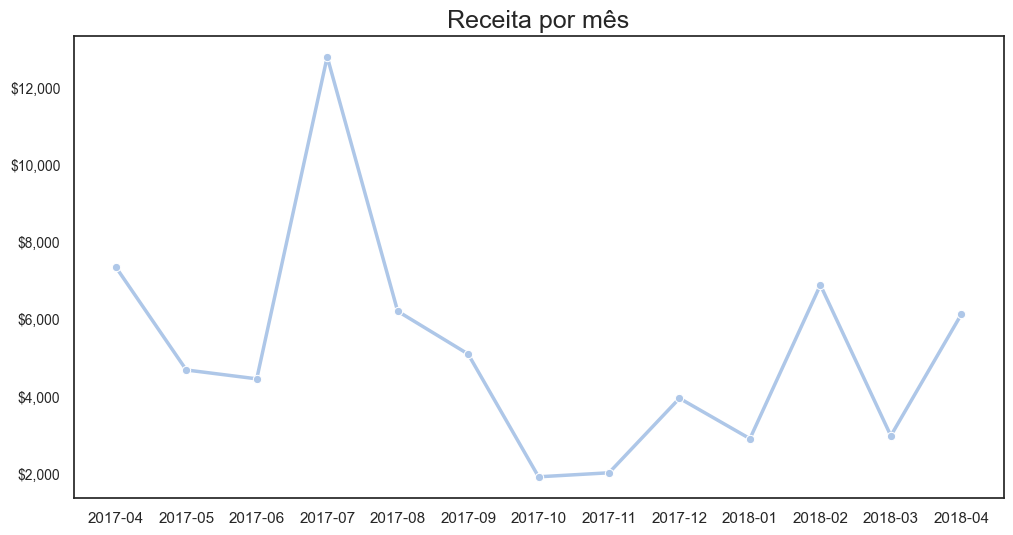

In [14]:
df_monthly_revenue = df_segmentation.query('date >= "2017-04-01"')[['date','revenue']]
df_monthly_revenue['visit_month'] = df_monthly_revenue['date'].dt.to_period('M').astype(str)
df_monthly_revenue = df_monthly_revenue.groupby('visit_month')['revenue'].sum()
df_monthly_revenue = df_monthly_revenue.to_frame().reset_index()

sns.set_theme(style="white", palette=None)
plt.figure(figsize = (12,6))

ax = sns.lineplot(data=df_monthly_revenue,
                  x='visit_month',
                  y='revenue',
                  color=colors[1],
                  linewidth=2.5,
                  marker="o")

ax.set(xlabel=None)
ax.set(ylabel=None)
vals = ax.get_yticks()
ax.set_yticklabels([f'${x:,.0f}' for x in vals], fontsize = 10)
ax.set_title('Receita por mês', fontsize=18)

Text(0.5, 1.0, 'Transações por país')

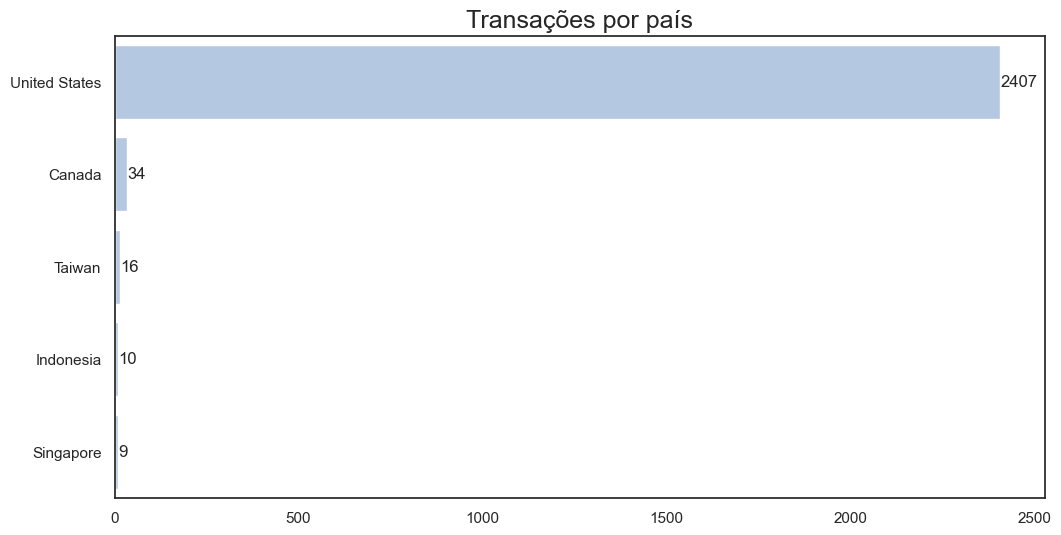

In [15]:
df_transactions_by_country = df_segmentation.groupby('country')['transaction_id'].count()
df_transactions_by_country = df_transactions_by_country.to_frame().reset_index()
df_transactions_by_country = df_transactions_by_country.query('transaction_id > 0')
df_transactions_by_country = df_transactions_by_country.sort_values('transaction_id', axis = 0, ascending = False).head(5)

sns.set_theme(style="white", palette=None)
plt.figure(figsize = (12,6))

ax = sns.barplot(df_transactions_by_country,
                y='country',
                x='transaction_id',
                color=colors[1])

ax.bar_label(ax.containers[0], fontsize=12)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set_title('Transações por país', fontsize=18)

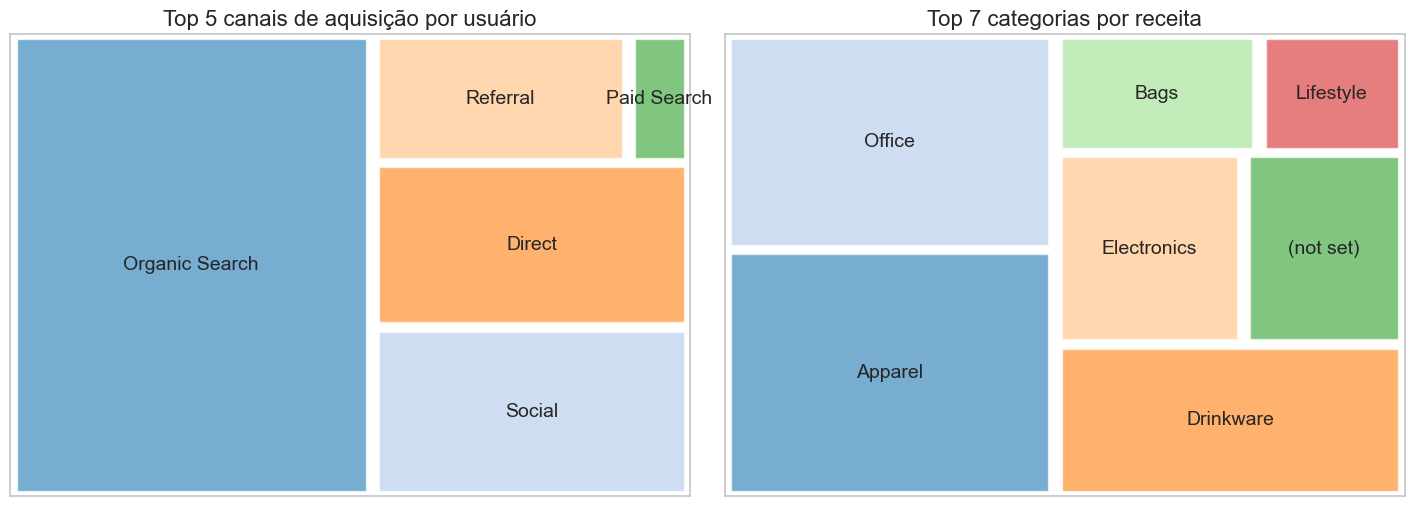

In [16]:
df_user_by_channel = df_segmentation.groupby('channel')['user_id'].nunique()
df_user_by_channel = df_user_by_channel.to_frame().reset_index()
df_user_by_channel = df_user_by_channel.sort_values('user_id', axis = 0, ascending = False).head(5)

df_revenue_by_category = df_segmentation.groupby('product_category')['revenue'].sum()
df_revenue_by_category = df_revenue_by_category.to_frame().reset_index()
df_revenue_by_category = df_revenue_by_category.sort_values('revenue', axis = 0, ascending = False).head(7)

fig, axs = plt.subplot_mosaic([['left','right']],figsize=(18, 6))

squarify.plot(sizes=df_user_by_channel['user_id'],
              label=df_user_by_channel['channel'],
              color=colors,
              pad=True,
              alpha=0.6,
              text_kwargs={'fontsize': 14},
                ax=axs['left'])

squarify.plot(sizes=df_revenue_by_category['revenue'],
              label=df_revenue_by_category['product_category'],
              color=colors,
              pad=True,
              alpha=0.6,
              text_kwargs={'fontsize': 14},
                ax=axs['right'])

fig.subplots_adjust(wspace=0.05)


for plot in ['right', 'left']:
    axs[plot].spines['right'].set_color(colors[15])
    axs[plot].spines['left'].set_color(colors[15])
    axs[plot].spines['bottom'].set_color(colors[15])
    axs[plot].spines['top'].set_color(colors[15])
    axs[plot].get_xaxis().set_ticks([])
    axs[plot].get_yaxis().set_ticks([])

    
axs['left'].set_title('Top 5 canais de aquisição por usuário', fontsize=16)
axs['right'].set_title('Top 7 categorias por receita', fontsize=16)


plt.show()

Como resultado da análise exploratória, pode-se perceber que:

- A taxa de conversão está em torno de 2%;
- A taxa de retorno dos usuários está em torno de 13%;
- A maior parte dos usuários e das transações tem origem nos Estados Unidos;
- A receita tem uma forte variação ao longo dos meses;
- O principal canal de acquisisão é busca orgânica;
- As categorias de produto que mais geram receita são: Office e Apparel.

Esse tipo de análise, além de ajudar a conhecer o conjunto de dados, contribui também para orientar e guiar análises futuras, como por exemplo:

- Que ações podem-se ser feitas para melhorar a taxa de conversão?
- Qual estratégia pode ser adotada para melhorar a taxa de retorno dos usuários?

### Segmentação de usuários:
Nessa seção, irei apresentar a segmentação dos usuários por **coorte** e pelo método **RFM**:

#### Análise de Coorte

A análise de coorte tem forte relação com a taxa de retorno dos usuários ao nosso site. Essa análise será feita para os clientes que visitaram o site nos últimos 12 meses (do conjunto de dados) e será feita tanto para todos os visitantes quando para os visitantes que realizaram alguma transação.

In [17]:
#segmentando a base de dados
df_cohort = df_segmentation.query('date >= "2017-05-01"')[['user_id','transaction_id']].copy()

#extraindo o mês a partir da data
df_cohort['visit_month'] = df_segmentation['date'].dt.to_period('M')

#determinando qual o primeiro mês no qual o usuário visitou o site
df_cohort['cohort'] = df_cohort.groupby('user_id')['visit_month'].transform('min')

In [18]:
#agrupando os usuários por mês e data da visita
df_cohort = df_cohort.groupby(['cohort', 'visit_month']).agg(n_customers=('user_id', 'nunique')).reset_index(drop=False)

#calculando o quantos periodos se passaram entre uma visita e a primeira visita
df_cohort['period_number'] = (df_cohort.visit_month - df_cohort.cohort).apply(attrgetter('n'))

In [19]:
#criando a matrix de retenção
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')

cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

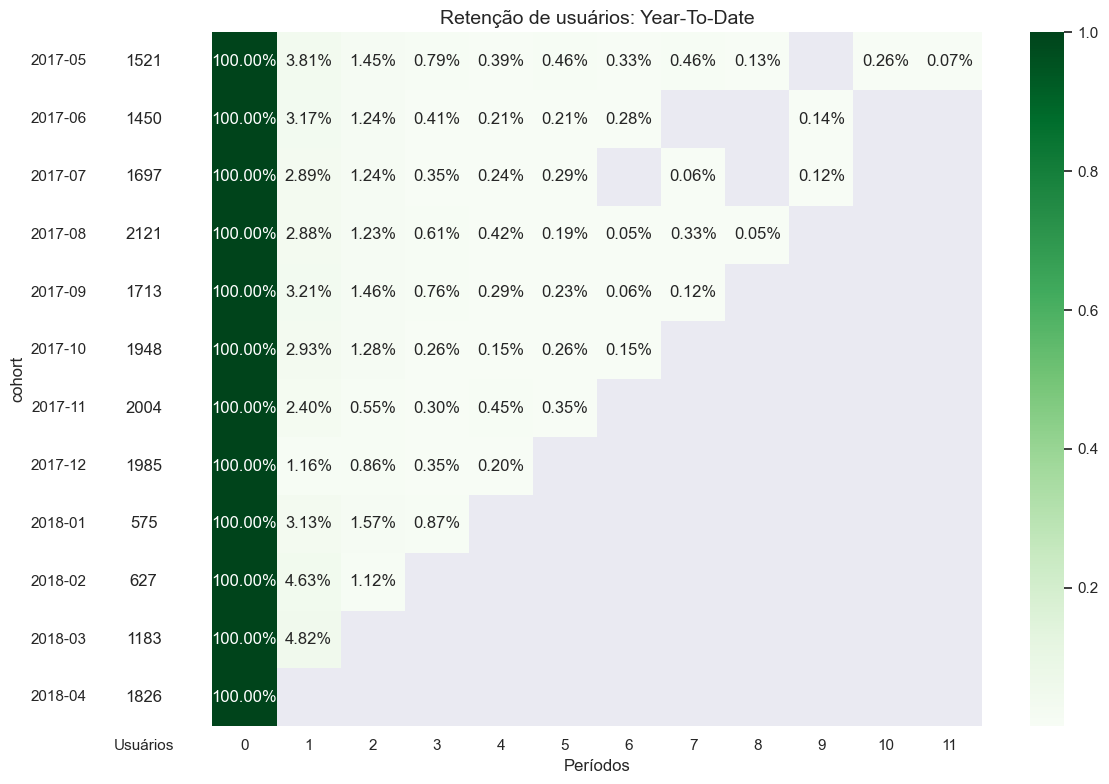

In [20]:
#plotando a matrix de retenção
with sns.axes_style("dark"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.2%', 
                cmap='Greens', 
                ax=ax[1])
    ax[1].set_title('Retenção de usuários: Year-To-Date', fontsize=14)
    ax[1].set(xlabel='Períodos',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'Usuários'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

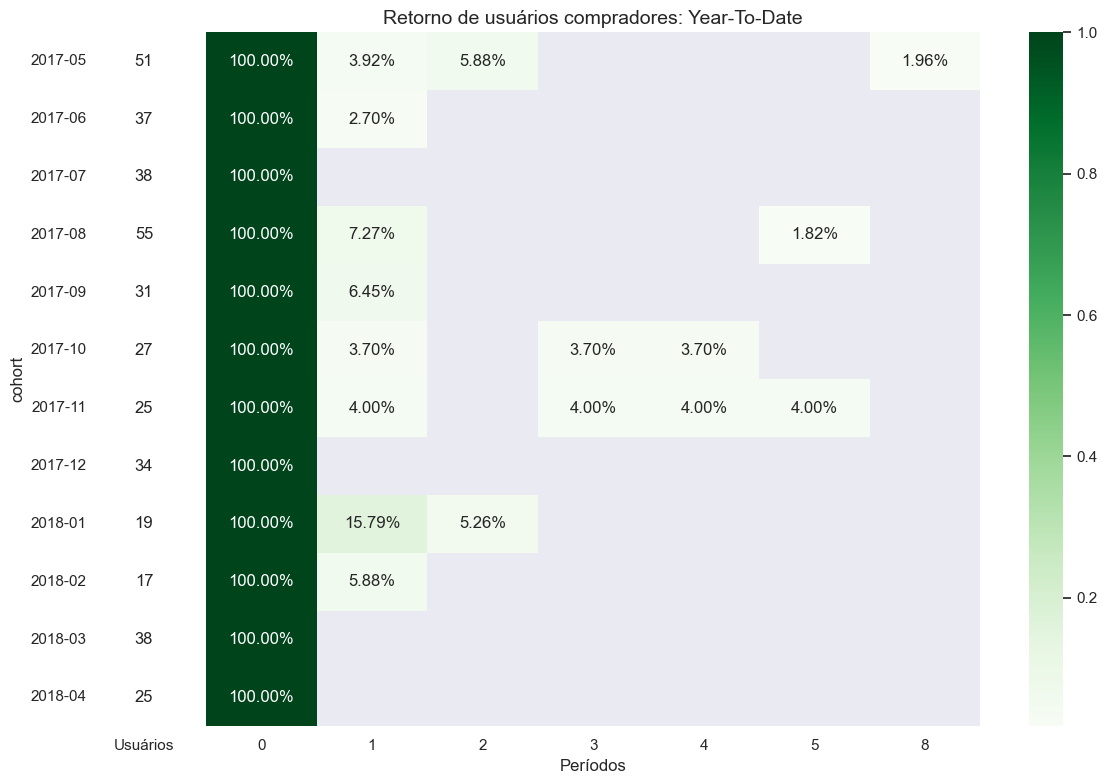

In [21]:
df_cohort_buyers = df_segmentation.query('date >= "2017-05-01" & is_transaction == "yes"')[['user_id','transaction_id']].copy()
df_cohort_buyers['visit_month'] = df_segmentation['date'].dt.to_period('M')

df_cohort_buyers['cohort'] = df_cohort_buyers.groupby('user_id')['visit_month'].transform('min')

df_cohort_buyers = df_cohort_buyers.groupby(['cohort', 'visit_month']).agg(
                    n_customers=('user_id', 'nunique')).reset_index(drop=False)

df_cohort_buyers['period_number'] = (df_cohort_buyers.visit_month - df_cohort_buyers.cohort).apply(attrgetter('n'))

cohort_pivot = df_cohort_buyers.pivot_table(index='cohort', columns='period_number', values='n_customers')

cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

with sns.axes_style("dark"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.2%', 
                cmap='Greens', 
                ax=ax[1])
    ax[1].set_title('Retorno de usuários compradores: Year-To-Date', fontsize=14)
    ax[1].set(xlabel='Períodos',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'Usuários'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

#### Insights da análise de coorte

Como já se esperava a partir análise exploratória, a taxa de retorno dos cleintes é muito baixa, mesmo dentre aqueles que já compraram na loja. A análise de coorte nos mostra então exatamente quando está ocorrendo as maiores variações na taxa de retorno do usuário para que se possa pensar em uma estratégia para trazer esses usuários de volta.

No caso dessa loja, os clientes não estão retornando um mês após a sua primeira visita e com essa informação pode-se pensar em duas ações:

- Caso exista um registro do e-mail do usuário e ele optou por receber e-mails promocionais na hora do cadastro, pode-se pensar em enviar um e-mail 30 dias após a primeira visita com algum voucher ou cupom para incentivar esse usuário a retornar e também a converter.
- Pode-se fazer uma estratégia semelhante ao e-mail marketing usando uma campanha de remarketing direcionada ao publico que está a mais de um mês sem visitar a loja.

### Análise RFM:

Nessa seção eu trago uma classificação por recência, frequência e momentário dos usuários que visitaram o site e fizeram alguma transação.

In [22]:
#segmentando a base de dados
df_buyers = df_segmentation.query('is_transaction == "yes"')[['date','user_id','transaction_id','revenue']].copy()

#calculando os valores para recencia, frequencia e monetario
df_recency = df_buyers.groupby('user_id',as_index=False)['date'].max()
df_recency.columns = ['user_id', 'max_date']

recency = df_recency['max_date'].max()
df_recency['recency'] = df_recency['max_date'].apply(lambda x: (recency - x).days)
df_recency = df_recency.drop('max_date', axis=1)

df_frequency = df_buyers.groupby('user_id',as_index=False)['date'].count()
df_frequency.columns = ['user_id', 'frequency']

df_monetary = df_buyers.groupby('user_id',as_index=False)['revenue'].sum()
df_monetary.columns = ['user_id', 'monetary']

df_rfm = df_recency.merge(df_frequency, on='user_id')
df_rfm = df_rfm.merge(df_monetary, on='user_id')

In [23]:
# Criando as regras de classificação para Recência, Frequência e Monetário
# Note que as regras não são as mesmas para cada métrica do método RFM
# Note também que pesos distintos podem ser atribuidos a cada métrica na hora de fazer o cálculo final do indice rfm.

df_rfm['r_metric'] = pd.qcut(df_rfm['recency'], 4, ['4','3','2','1']).astype(np.int64)

df_rfm.loc[df_rfm['frequency'] == 1, 'f_metric'] = 1
df_rfm.loc[df_rfm['frequency'] == 2, 'f_metric'] = 3
df_rfm.loc[df_rfm['frequency'] >= 3, 'f_metric'] = 4

df_rfm['m_metric'] = pd.qcut(df_rfm['monetary'], 4, ['1','2','3','4']).astype(np.int64)

# Calculando o valor de RFM
df_rfm['rfm'] = (df_rfm['r_metric'] + df_rfm['f_metric'] + 2*df_rfm['m_metric']) / 4
df_rfm.head()

,user_id,recency,frequency,monetary,r_metric,f_metric,m_metric,rfm
0,1018592359219015183,410,2,115.980000,2,3.0,3,2.75
1,1035287577797151816,320,1,42.380000,3,1.0,2,2.00
2,1045026996395835243,174,11,111.289999,4,4.0,3,3.50
3,1049505592515499633,503,1,42.980000,1,1.0,2,1.50
4,1059009151425872003,446,1,13.790000,2,1.0,1,1.25


In [24]:
#analisando as caracteristas de cada métrica e do indice rfm
df_rfm.describe()

,recency,frequency,monetary,r_metric,f_metric,m_metric,rfm
count,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000
mean,331.479374,3.597440,170.824722,2.507824,2.761024,2.499289,2.566856
std,179.075258,5.344416,489.261172,1.116891,1.318211,1.119466,0.812766
min,0.000000,1.000000,5.590000,1.000000,1.000000,1.000000,1.000000
25%,196.000000,1.000000,28.275000,2.000000,1.000000,1.500000,2.000000
50%,335.000000,2.000000,56.490000,3.000000,3.000000,2.000000,2.750000
75%,495.000000,4.000000,125.174999,4.000000,4.000000,3.500000,3.250000
max,637.000000,90.000000,7073.509970,4.000000,4.000000,4.000000,4.000000


In [25]:
# Rotulando os clientes de acordo com seu indice rfm
df_rfm.loc[df_rfm['rfm'] == 4, 'category'] = 'Campeões'
df_rfm.loc[df_rfm['rfm'] < 4, 'category'] = 'Clientes Fiéis'
df_rfm.loc[df_rfm['rfm'] < 3, 'category'] = 'Fiéis em Potencial'
df_rfm.loc[df_rfm['rfm'] < 2, 'category'] = 'Em Risco'
df_rfm.loc[df_rfm['rfm'] == 1, 'category'] = 'Perdidos'

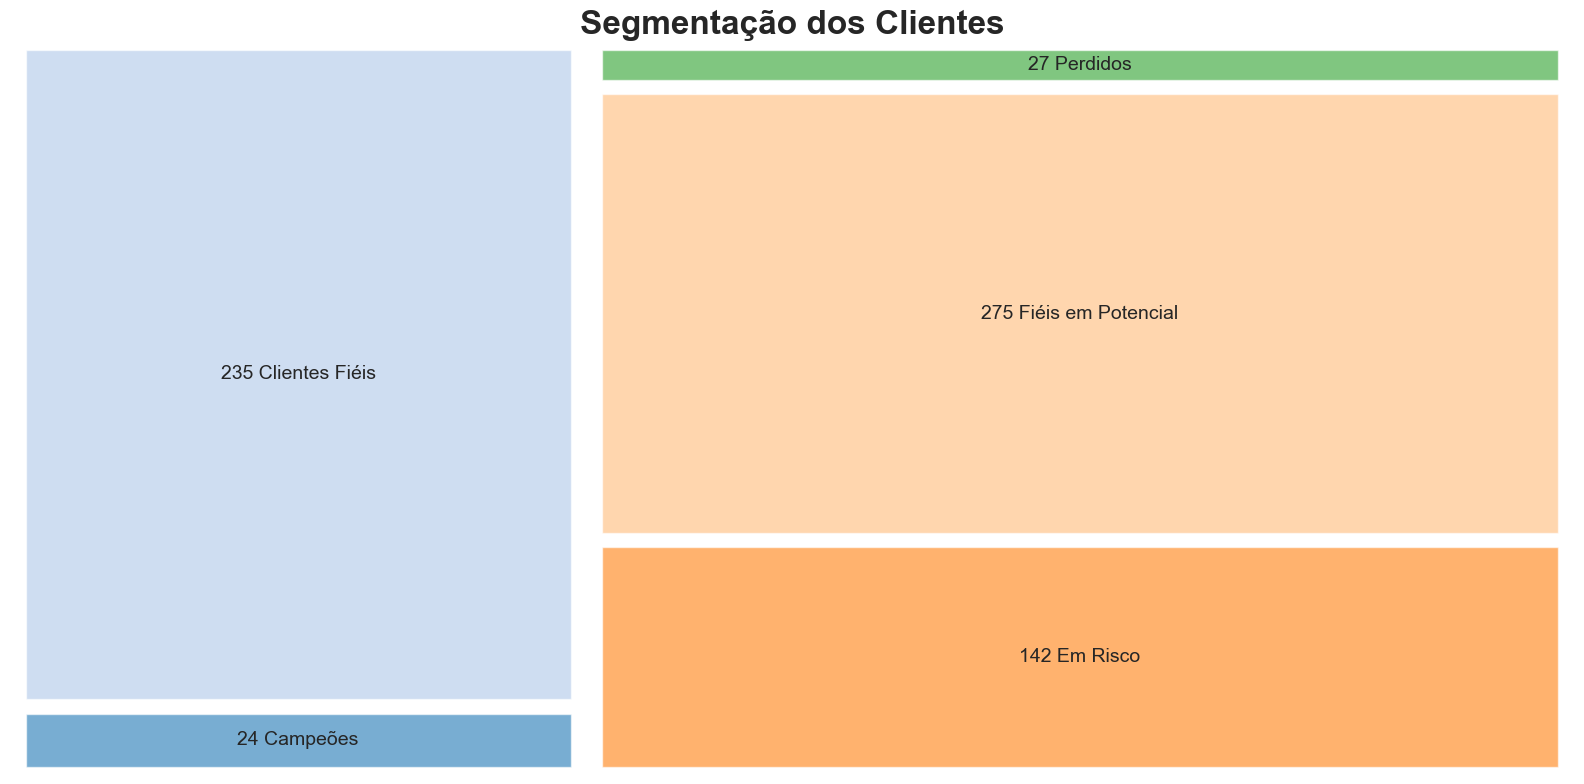

In [26]:
# calculando a quantidade de clientes em cada categoria
df_categorias = df_rfm.groupby(['category'], as_index=False)['rfm'].count()
df_categorias.rename(columns={'rfm':'amount'}, inplace=True)

# criando gráfico de segmentacao
fig, ax = plt.subplots(figsize=(16,8))
squarify.plot(sizes=df_categorias['amount'],
              label=df_categorias['amount'].astype(str) + ' ' + df_categorias['category'],
              color=colors,
              pad=True,
              alpha=0.6,
              text_kwargs={'fontsize': 14})

plt.title('Segmentação dos Clientes',
          fontsize=24,
          fontweight="bold")

plt.axis('off')
plt.tight_layout()

plt.show()

#### Insights da análise RFM

Da base de clientes, poucos se classificam como clientes campeões. Isso já era esperado devido a regra de que clientes campões teriam que pontuar a nota máxima em todas as categórias.

Contudo, o dado relevante aqui não é o número de clientes campeões mas sim o número de clientes nas outras categorias e quais estratégias podem ser adotadas para motivar esses clientes a realizarem mais uma visita e mais uma compra na loja. Essas estratégias passam também por ações de e-mail marketing e campanhas de remarketing específicas para cada grupo, oferecendo descontos ou apenas se relacionando com o cliente.

### Análise de Cesta de Produtos:

Nessa seção eu utilizo o algoritmo de apriori para análisar as relações entre os produtos vendidos e identificar os pares de produtos que mais são vendidos juntos.

Text(0.5, 1.0, 'Produtos mais frequentes nos carrinhos de compra')

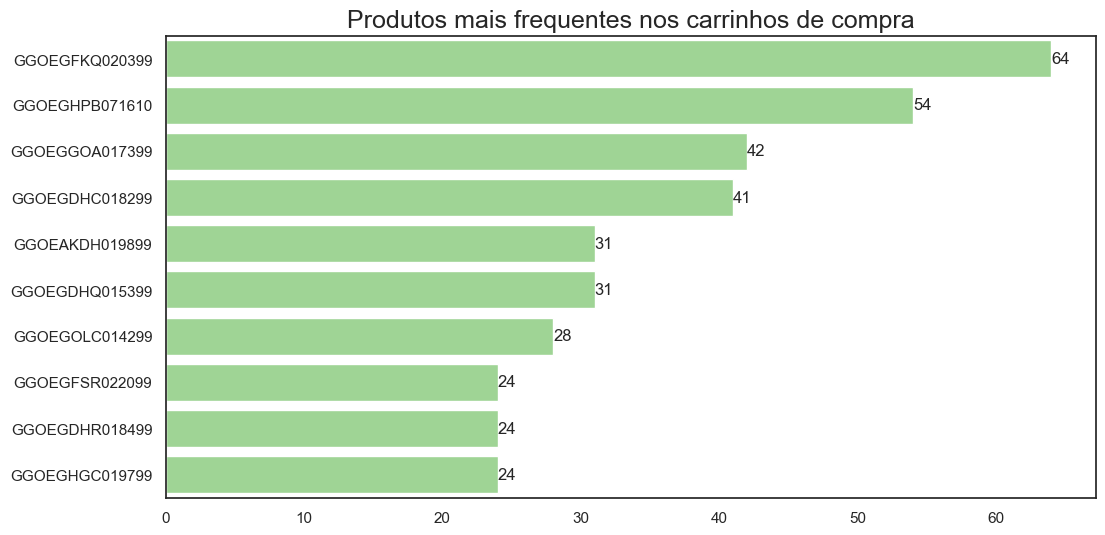

In [27]:
#analisando os produtos que mais aparecem nas transações
#note que não é a quantidade de produtos mais vendidos, pois mais de uma unidade do produto pode ser vendida em uma transação
df_products = df_segmentation.groupby('product_sku')['transaction_id'].count()
df_products = df_products.to_frame().reset_index()
df_products = df_products.query('transaction_id > 0')
df_products = df_products.sort_values('transaction_id', axis = 0, ascending = False).head(10)

sns.set_theme(style="white", palette=None)
plt.figure(figsize = (12,6))

ax = sns.barplot(df_products,
                y='product_sku',
                x='transaction_id',
                color=colors[5])

ax.bar_label(ax.containers[0], fontsize=12)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set_title('Produtos mais frequentes nos carrinhos de compra', fontsize=18)

In [28]:
#segmentando a base de dados
df_basket = df_segmentation.query('date >= "2018-01-01" & is_transaction == "yes"')[['transaction_id','product_sku']].copy()

In [29]:
#constroi uma tabela de frequencia para cada item
df_basket = pd.crosstab(df_basket['transaction_id'], df_basket['product_sku'])
df_basket.shape

(116, 101)

In [30]:
#transforma a tabela anterior em uma tabela booleana, os valores de frequência não são relevantes para o algoritmo,
#o dados relevante é se a celula possuí ou não algum valor e fazemos isso com o True/False para melhorar a performance
def encode(item_freq):
    res = False
    if item_freq > 0:
        res = True
    return res
    
df_basket = df_basket.map(encode)

In [31]:
#importando as bibliotecas que possuem o algoritmo
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(df_basket, min_support=0.01, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift")

#listando os 5 pares de produtos com maior propensão de serem comprados juntos
rules.sort_values(["support", "confidence","lift"],axis = 0, ascending = False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
92,(GGOEGHGH019699),(GGOEGHGC019799),0.043103,0.043103,0.043103,1.0,23.2,0.041246,inf,1.000000
93,(GGOEGHGC019799),(GGOEGHGH019699),0.043103,0.043103,0.043103,1.0,23.2,0.041246,inf,1.000000
94,(GGOEGHGR019499),(GGOEGHGC019799),0.034483,0.043103,0.034483,1.0,23.2,0.032996,inf,0.991071
98,(GGOEGHGR019499),(GGOEGHGH019699),0.034483,0.043103,0.034483,1.0,23.2,0.032996,inf,0.991071
230,"(GGOEGHGR019499, GGOEGHGH019699)",(GGOEGHGC019799),0.034483,0.043103,0.034483,1.0,23.2,0.032996,inf,0.991071


#### Insights da análise de cesta

Esses pares de correspondência podem servir como orientação para realizar campanhas de marketing colocando pares de produto similares juntos ou direcionar a escrita de e-maild promocionais. Esse tipo de análise é muito utilizado também para mostrar sugestões em tempo real de produtos similares enquanto o usuário navega pelo site.

Um fato interessante é que alguns dos produtos que mais apareceram nas transações não figuram nessa lista, ou seja, se a análise fosse apenas exploratória, as orientações passadas para a equipe de marketing sobre as relações sobre os produtos poderiam não ser adequadas.

### Análise propensão de compra:

Nessa seção, têm-se uma análise de propensão de compra:

In [32]:
#Carregando nova base de dados
df_propensity = pd.read_csv(r'C:\Users\natferna5\Documents\Estudos\Git\Studies\google_merchandising_analysis\user_propensity.csv',
                 dtype={'date': 'string',
                        'user_id': 'string',
                        'is_transaction': 'string',
                        'is_click': 'int64',
                        'is_impression': 'int64',
                        'hit_number': 'int64',
                        'true_direct': 'int64',
                        'visit_number': 'int64',
                        'totals_pageviews': 'int64',
                        'totals_hits': 'int64',
                        'totals_timeonsite': 'int64'},
                 parse_dates=['date'])

In [33]:
df_propensity.head()

,date,user_id,is_transaction,is_click,is_impression,hit_number,true_direct,visit_number,totals_pageviews,totals_hits,totals_timeonsite
0,2016-08-01,116436763018562710,no,0,1,5,1,2,4,5,35
1,2016-08-01,1621472397271519979,no,0,1,3,0,1,5,5,51
2,2016-08-01,211067802416163706,no,0,1,15,1,1,16,16,455
3,2016-08-01,2138249057628555204,no,0,1,3,0,1,2,3,19
4,2016-08-01,2215681073032687184,no,0,0,7,1,1,6,7,195


In [34]:
df_propensity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58164 entries, 0 to 58163
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               58164 non-null  datetime64[ns]
 1   user_id            58164 non-null  string        
 2   is_transaction     58164 non-null  string        
 3   is_click           58164 non-null  int64         
 4   is_impression      58164 non-null  int64         
 5   hit_number         58164 non-null  int64         
 6   true_direct        58164 non-null  int64         
 7   visit_number       58164 non-null  int64         
 8   totals_pageviews   58164 non-null  int64         
 9   totals_hits        58164 non-null  int64         
 10  totals_timeonsite  58164 non-null  int64         
dtypes: datetime64[ns](1), int64(8), string(2)
memory usage: 4.9 MB


In [35]:
df_propensity.describe()

,date,is_click,is_impression,hit_number,true_direct,visit_number,totals_pageviews,totals_hits,totals_timeonsite
count,58164,58164.000000,58164.000000,58164.000000,58164.000000,58164.000000,58164.000000,58164.000000,58164.000000
mean,2017-06-22 15:50:35.527130368,0.187384,0.603157,9.335792,0.349374,2.179647,8.540902,11.236744,314.344491
min,2016-08-01 00:00:00,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,2017-01-22 00:00:00,0.000000,0.000000,2.000000,0.000000,1.000000,2.000000,2.000000,17.000000
50%,2017-07-09 00:00:00,0.000000,1.000000,5.000000,0.000000,1.000000,5.000000,6.000000,99.000000
75%,2017-11-13 00:00:00,0.000000,1.000000,11.000000,1.000000,2.000000,11.000000,14.000000,341.000000
max,2018-04-30 00:00:00,1.000000,1.000000,500.000000,1.000000,185.000000,365.000000,500.000000,13098.000000
std,NaN,0.390223,0.489247,15.091852,0.476776,6.022255,11.371120,16.211045,573.741394


In [36]:
#seleciando quais colunas são base para o modelo e qual coluna é o objetivo do modelo
predictors = df_propensity.query('date >= "2018-01-01"').drop(
            ['date','user_id','is_transaction'], axis=1) 
targets = df_propensity.query('date >= "2018-01-01"')['is_transaction']

In [37]:
#importando bibliotecas com o algoritmo do modelo
from sklearn.model_selection  import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

X_train, X_test, y_train, y_test = train_test_split(predictors, targets, test_size=.3)

print( "Predictor - Training : ", X_train.shape, "Predictor - Testing : ", X_test.shape )

Predictor - Training :  (6051, 8) Predictor - Testing :  (2594, 8)


In [38]:
from sklearn.naive_bayes import GaussianNB

classifier=GaussianNB()
classifier=classifier.fit(X_train,y_train)

predictions=classifier.predict(X_test)

#testando acuracia do modelo
sklearn.metrics.confusion_matrix(y_test,predictions)

array([[2374,  179],
       [   8,   33]], dtype=int64)

In [39]:
#testando acuracia do modelo
sklearn.metrics.accuracy_score(y_test, predictions)

0.9279105628373169

In [40]:
#aplicando o modelo para uma segmentação diferente de usuários, que não foi usada para construir o modelo
df_applying_model = df_propensity.query('date < "2018-01-01"')

df_applying_model_droped = df_applying_model.drop(['date','user_id','is_transaction'], axis=1)

df_applying_model_droped['propensity'] = classifier.predict_proba(df_applying_model_droped)[:,1]

results = pd.concat([df_applying_model[['date','user_id','is_transaction']],
                     df_applying_model_droped['propensity']], axis=1)

results.head()

,date,user_id,is_transaction,propensity
0,2016-08-01,116436763018562710,no,0.000000
1,2016-08-01,1621472397271519979,no,0.000000
2,2016-08-01,211067802416163706,no,0.000000
3,2016-08-01,2138249057628555204,no,0.000000
4,2016-08-01,2215681073032687184,no,0.190422


In [41]:
#validando os resultados analisando a propensão de compra de quem realizou alguma compra,
results.query('is_transaction == "yes"').describe()

,date,propensity
count,704,704.000000
mean,2017-04-15 13:44:19.090908928,0.831105
min,2016-08-01 00:00:00,0.051568
25%,2016-12-14 00:00:00,0.718999
50%,2017-04-26 00:00:00,0.997229
75%,2017-08-15 06:00:00,1.000000
max,2017-12-31 00:00:00,1.000000
std,NaN,0.271863


In [42]:
users_without_propensity_score = results.query('is_transaction == "no" & propensity == 0')['user_id'].nunique()
users_with_propensity_score = results.query('is_transaction == "no" & propensity > 0')['user_id'].nunique()

print('Usuários que nunca compraram e não possuem propensão: %i' % (users_without_propensity_score),
     '\nUsuários que nunca compraram com propensão:  %i' % (users_with_propensity_score))

Usuários que nunca compraram e não possuem propensão: 25186 
Usuários que nunca compraram com propensão:  7023


In [43]:
#analisando a propensão de compra de quem não comprou e possui propensão maior que zero
users_with_propensity = results.query('is_transaction == "no" & propensity > 0')

users_with_propensity.describe()

,date,propensity
count,8868,8868.000000
mean,2017-04-27 07:30:46.278755072,0.392969
min,2016-08-01 00:00:00,0.026539
25%,2016-12-08 00:00:00,0.053653
50%,2017-05-08 00:00:00,0.209325
75%,2017-09-16 00:00:00,0.810169
max,2017-12-31 00:00:00,1.000000
std,NaN,0.377795


In [44]:
users_with_propensity_greater_than_50perc = results.query(
    'is_transaction == "no" & propensity > 0.5')['user_id'].drop_duplicates().reset_index(drop=True)

number_of_user = users_with_propensity_greater_than_50perc.count()

print('Usuários que não compraram e possuem propensão acima de 50%%: %i' % (number_of_user))

Usuários que não compraram e possuem propensão acima de 50%: 2294


In [45]:
#O valor acima pode incluir clientes que já compraram, mas que em um visita anterior ou posterior não compraram nada
#É necessário analisar quantos usuários estão nessa situação e retirá-los da lista

buyers = results.query('is_transaction == "yes"')['user_id'].drop_duplicates().reset_index(drop=True)

list_of_interesting_users = users_with_propensity_greater_than_50perc[
                                    ~users_with_propensity_greater_than_50perc.isin(buyers)].reset_index(drop=True)

number_of_user = list_of_interesting_users.count()

print('Usuários que nunca compraram e possuem propensão acima de 50: %i' % (number_of_user))

Usuários que nunca compraram e possuem propensão acima de 50: 1781


In [46]:
#finalmente, pode-se exportar uma lista dos usuários com propensão de compra relevante
list_of_interesting_users.to_csv('list_of_interesting_users.csv')

#### Insights da análise de propensão de compra

Dos 25186 usuários que nunca realizaram nenhuma compra no período anterior a 2018, nosso modelo marcou 1583 como tendo um propensão de compra maior do que 50% e, de posso desse dados, podemos pensar em campanhas de remarketing especificas para esse público.

Esse público de 1583 usuários com propensão de compra relevante possui um tamanho interessante, pois é mais que o dobro do número de usuários que compraram na loja e apenas cerca de 10% da base total de usuários. Isso se traduz em um público qualificado para ser impacto por campanhas de remarketing e servir também de look alike para geração de outros públicos semelhantes. Espera-se que usando esses públicos segmentados os resultados das campanhas sejam mais efetivos que os resultados das campanhas usando público não segmentado.